In [1]:
#next line is another way to install imblearn without using terminal
!pip3 install imblearn
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.regression.linear_model as smr
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import impute
from sklearn.impute import KNNImputer
import sklearn as sk
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings("ignore")

PCOS = pd.read_csv("PCOS.csv")
PCOS.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', 'Age (yrs)', 'Weight (Kg)',
       'Height(Cm)', 'BMI', 'Blood Group', 'Pulse rate(bpm)',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44'],
      dtype='object')

In [2]:
data = PCOS.loc[:, ["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "Hip(inch)", "Waist(inch)", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group"]]
data["H/W Ratio"] = data["Hip(inch)"]/data["Waist(inch)"]
data["Height(M)"] = data["Height(Cm)"]/100
data["BMI"] = data["Weight (Kg)"]/np.square(data["Height(M)"])
data = data.reindex(columns=["PCOS (Y/N)", "Age (yrs)", "Weight (Kg)", "Height(Cm)", "BMI", "Pulse rate(bpm)", "RR (breaths/min)", "Marraige Status (Yrs)", 'Fast food (Y/N)', "Pregnant(Y/N)", "No. of aborptions", "H/W Ratio", "Reg.Exercise(Y/N)", "Cycle(R/I)", "hair growth(Y/N)", "Pimples(Y/N)", "Blood Group"])
missing_cols = data.columns[data.isna().any()].tolist()
for x in missing_cols:
    data[x] = data[x].fillna(data[x].mean())

In [3]:
def confusion_matrix_train(model, cutoff=0.5):
# Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))
    
def confusion_matrix_test(data,actual_values,model,cutoff=0.3):
    #Predict the values using the Logit model
    pred_values = model.predict(data)
    # Specify the bins
    bins=np.array([0,cutoff,1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    # Return the confusion matrix and the accuracy
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))

## Analysis Part 2

    Method for this part is more for stakeholders (medical professionals) since these variables are easier to observe physically (not seperating hip and waist like in others' analysis in order to see if they can individually impact). 

In [4]:
ob_vars = PCOS.loc[:, ["PCOS (Y/N)","Age (yrs)",
       'Height(Cm)','Pregnant(Y/N)', 'Hip(inch)', 'Waist(inch)', 'BMI',
                    'Weight gain(Y/N)',
                    "hair growth(Y/N)", 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', "Pimples(Y/N)"]]

In [5]:
ob_vars

,PCOS (Y/N),Age (yrs),Height(Cm),Pregnant(Y/N),Hip(inch),Waist(inch),BMI,Weight gain(Y/N),hair growth(Y/N),hair growth(Y/N),Skin darkening (Y/N),Hair loss(Y/N),Pimples(Y/N)
0,0,28,152.000,0,36,30,19.3,0,0,0,0,0,0
1,0,36,161.500,1,38,32,#NAME?,0,0,0,0,0,0
2,1,33,165.000,1,40,36,#NAME?,0,0,0,0,1,1
3,0,37,148.000,0,42,36,#NAME?,0,0,0,0,0,0
4,0,25,161.000,1,37,30,#NAME?,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,35,164.592,0,28,26,18.5,0,0,0,0,0,0
537,0,30,158.000,1,34,32,25.3,1,0,0,0,0,0
538,0,36,152.000,0,30,28,23.4,0,0,0,0,0,0
539,0,27,150.000,0,28,26,22.2,0,0,0,0,0,1


In [6]:
cleaned_ob_vars = ob_vars[~ob_vars['Age (yrs)'].isnull()]

In [7]:
obs = cleaned_ob_vars.rename(columns={"PCOS (Y/N)": "PCOS", 'Age (yrs)': 'age',
       'Height(Cm)':'height', 'Pregnant(Y/N)':'pregnant', 'Hip(inch)': 'hip', 'Waist(inch)': 'waist', 'Weight gain(Y/N)': 'weight_gain',
                    "hair growth(Y/N)": "hair_growth",
       'Skin darkening (Y/N)': 'skin_darkening', 'Hair loss(Y/N)': 'hair_loss', "Pimples(Y/N)": "pimples"})

In [8]:
obs

,PCOS,age,height,pregnant,hip,waist,BMI,weight_gain,hair_growth,hair_growth,skin_darkening,hair_loss,pimples
0,0,28,152.000,0,36,30,19.3,0,0,0,0,0,0
1,0,36,161.500,1,38,32,#NAME?,0,0,0,0,0,0
2,1,33,165.000,1,40,36,#NAME?,0,0,0,0,1,1
3,0,37,148.000,0,42,36,#NAME?,0,0,0,0,0,0
4,0,25,161.000,1,37,30,#NAME?,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,35,164.592,0,28,26,18.5,0,0,0,0,0,0
537,0,30,158.000,1,34,32,25.3,1,0,0,0,0,0
538,0,36,152.000,0,30,28,23.4,0,0,0,0,0,0
539,0,27,150.000,0,28,26,22.2,0,0,0,0,0,1


In [9]:
columns = '+'.join(obs.columns.drop("PCOS"))

In [10]:
pred = smf.ols(formula = 'PCOS~' + columns, data = obs) 
model_1 = pred.fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PCOS   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     4.668
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           1.04e-31
Time:                        13:32:16   Log-Likelihood:                -133.97
No. Observations:                 541   AIC:                             503.9
Df Residuals:                     423   BIC:                             1011.
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0176      0.472     -0.037      0.970      -0.945       0.910
BMI[T.15.1]        1.0579      0.358      2.951      0.003       0.353       1.762
BMI[T.15.8]       -0.1939      0.254     -0.764      0.445      -0.693       0.305
BMI[T.16]          0.9217      0.354      2.604      0.010       0.226       1.617
BMI[T.16.5]       -0.0161      0.355     -0.045      0.964      -0.713       0.681
BMI[T.16.6]        0.5165      0.357      1.445      0.149      -0.186       1.219
BMI[T.16.9]        1.1600      0.359      3.232      0.001       0.454       1.866
BMI[T.17.2]       -0.0496      0.355     -0.140      0.889      -0.747       0.647
BMI[T.17.3]       -0.1221      0.360     -0.339      0.735      -0.829       0.585
BMI[T.17.6]       -0.5463      0.359     -1.520      0.129      -1.253       0.160
BMI[T.17.7]        0.3314      0.256      1.295      0.196      -0.172       0.834
BMI[T.18]          0.7971      0.356      2.241      0.026       0.098       1.496
BMI[T.18.1]       -0.0781      0.359     -0.217      0.828      -0.784       0.628
BMI[T.18.2]        0.0768      0.354      0.217      0.828      -0.619       0.772
BMI[T.18.3]        0.1740      0.358      0.486      0.627      -0.530       0.878
BMI[T.18.5]        0.1954      0.359      0.545      0.586      -0.509       0.900
BMI[T.18.8]       -0.3608      0.356     -1.014      0.311      -1.060       0.338
BMI[T.19.1]       -0.0388      0.209     -0.186      0.853      -0.449       0.371
BMI[T.19.2]       -0.1033      0.207     -0.499      0.618      -0.511       0.304
BMI[T.19.3]        0.0682      0.251      0.272      0.786      -0.424       0.561
BMI[T.19.4]        0.5251      0.356      1.475      0.141      -0.175       1.225
BMI[T.19.6]        0.1393      0.356      0.391      0.696      -0.561       0.839
BMI[T.19.7]        0.1041      0.254      0.409      0.683      -0.396       0.604
BMI[T.19.8]        0.6040      0.356      1.694      0.091      -0.097       1.305
BMI[T.20]          0.2716      0.206      1.317      0.189      -0.134       0.677
BMI[T.20.3]        0.0168      0.254      0.066      0.947      -0.483       0.517
BMI[T.20.4]       -0.0574      0.181     -0.317      0.751      -0.413       0.299
BMI[T.20.5]        0.9892      0.358      2.764      0.006       0.286       1.693
BMI[T.20.8]       -0.1188      0.207     -0.573      0.567      -0.526       0.289
BMI[T.21]          0.2932      0.252      1.165      0.245      -0.202       0.788
BMI[T.21.1]        0.3748      0.209      1.798      0.073      -0.035       0.785
BMI[T.21.2]       -0.0973      0.354     -0.275      0.784      -0.794       0.599
BMI[T.21.3]       -0.1048      0.253     -0.414      0.679      -0.602       0.392
BMI[T.21.5]       -0.0652      0.254     -0.257      0.798      -0.564       0.434
BMI[T.21.6] 

In [11]:
needed = ob_vars.loc[:, ["Hip(inch)", "Waist(inch)"]]
needed

,Hip(inch),Waist(inch)
0,36,30
1,38,32
2,40,36
3,42,36
4,37,30
...,...,...
536,28,26
537,34,32
538,30,28
539,28,26


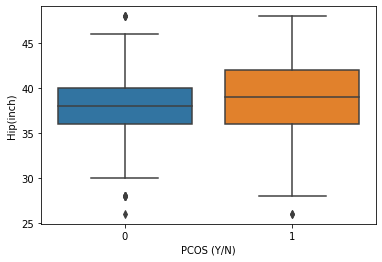

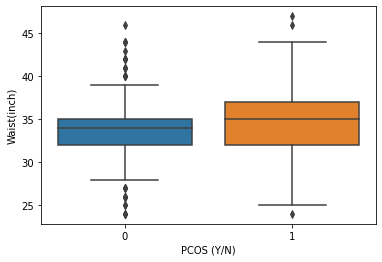

In [12]:
for y in needed.columns:
    sns.boxplot(y=y, x="PCOS (Y/N)", data=ob_vars)
    plt.show()

    Other EDA (for categorical variables) already done in others' Github branches.

## Using Ridge and Lasso Regression

### Modified SMOTE

In [13]:
PCOS = PCOS.rename(columns={"Sl. No":"num", "Patient File No.": "patient", "PCOS (Y/N)":"PCOS", "Age (yrs)": "age", 
       'Weight (Kg)' : "weight", 'Height(Cm)':"height", "Blood Group": "blood_group",'Pulse rate(bpm)': "pulse_rate",
       'RR (breaths/min)': "RR", 'Hb(g/dl)': "hb", 'Cycle(R/I)': "cycle_ri", 'Cycle length(days)': "cycle",
       'Marraige Status (Yrs)': "marriage_years", 'Pregnant(Y/N)': "pregnant", 'No. of aborptions': "number_abortions",
       '  I   beta-HCG(mIU/mL)': "I", 'II    beta-HCG(mIU/mL)': "II", 'FSH(mIU/mL)': "FAH",
       'LH(mIU/mL)': "LH", 'FSH/LH': "FSH_LH",
       'TSH (mIU/L)': "TSH", 'AMH(ng/mL)': "AMH", 'PRL(ng/mL)':"PRL", 'Vit D3 (ng/mL)': "vit",
       'PRG(ng/mL)':"prg", 'RBS(mg/dl)':"rbs", 'Weight gain(Y/N)':"weight_gain", 'hair growth(Y/N)':"hair_growth",
       'Skin darkening (Y/N)': "skin_dark", 'Hair loss(Y/N)': "hair_loss", 'Pimples(Y/N)': "pimples",
       'Fast food (Y/N)': "fast_food", 'Reg.Exercise(Y/N)':"regular_exercise", 'BP _Systolic (mmHg)':"bp_systolic",
       'BP _Diastolic (mmHg)': "bp_distolic", 'Follicle No. (L)':"follicle_L", 'Follicle No. (R)': "follicle_R",
       'Avg. F size (L) (mm)':"ave_size_L", 'Avg. F size (R) (mm)':"ave_size_R", 'Endometrium (mm)':"endometrium", 'Unnamed: 44':"NA"})

In [14]:
PCOS

,num,patient,PCOS,age,weight,height,BMI,blood_group,pulse_rate,RR,...,fast_food,regular_exercise,bp_systolic,bp_distolic,follicle_L,follicle_R,ave_size_L,ave_size_R,endometrium,NA
0,1,1,0,28,44.6,152.000,19.3,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.500,#NAME?,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.000,#NAME?,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.000,#NAME?,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.000,#NAME?,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,537,537,0,35,50.0,164.592,18.5,17,72,16,...,0.0,0,110,70,1,0,17.5,10.0,6.7,NaN
537,538,538,0,30,63.2,158.000,25.3,15,72,18,...,0.0,0,110,70,9,7,19.0,18.0,8.2,NaN
538,539,539,0,36,54.0,152.000,23.4,13,74,20,...,0.0,0,110,80,1,0,18.0,9.0,7.3,NaN
539,540,540,0,27,50.0,150.000,22.2,15,74,20,...,0.0,0,110,70,7,6,18.0,16.0,11.5,NaN


In [15]:
PCOS['blood_group']

0      15
1      15
2      11
3      13
4      11
       ..
536    17
537    15
538    13
539    15
540    13
Name: blood_group, Length: 541, dtype: int64

In [16]:
PCOS = PCOS.drop(columns = {'NA'})
PCOS = PCOS.drop(columns = {'blood_group'})
PCOS = PCOS.drop(columns = {'BMI'})
PCOS = PCOS.drop(columns = {'Waist(inch)'})
PCOS = PCOS.drop(columns = {'Waist:Hip Ratio'})
PCOS["height"] = PCOS["height"]/100
PCOS.isnull().sum()

num                 0
patient             0
PCOS                0
age                 0
weight              0
height              0
pulse_rate          0
RR                  0
hb                  0
cycle_ri            0
cycle               0
marriage_years      1
pregnant            0
number_abortions    0
I                   0
II                  0
FAH                 0
LH                  0
FSH_LH              0
Hip(inch)           0
TSH                 0
AMH                 0
PRL                 0
vit                 0
prg                 0
rbs                 0
weight_gain         0
hair_growth         0
skin_dark           0
hair_loss           0
pimples             0
fast_food           1
regular_exercise    0
bp_systolic         0
bp_distolic         0
follicle_L          0
follicle_R          0
ave_size_L          0
ave_size_R          0
endometrium         0
dtype: int64

In [17]:
PCOS = PCOS[~((PCOS['marriage_years'].isnull()) | (PCOS['fast_food'].isnull()))]
PCOS["PCOS"].value_counts()

0    363
1    176
Name: PCOS, dtype: int64

In [18]:
count_class_0, count_class_1 = PCOS.PCOS.value_counts()

# Divide by class
df_class_0 = PCOS[PCOS['PCOS'] == 0] #majority class
df_class_1 = PCOS[PCOS['PCOS'] == 1] #minority class

# Sample Majority class (y=0, to have same number of records as minority calls (y=1)
df_class_0_under = df_class_0.sample(count_class_1)
# join the dataframes containing y=1 and y=0
df_test_under = pd.concat([df_class_0_under, df_class_1])

In [19]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.PCOS.value_counts())
pcos = df_test_over
pcos.shape

Random over-sampling:
0    363
1    363
Name: PCOS, dtype: int64


(726, 40)

In [20]:
np.random.seed(2)
train = pcos.sample(round(data.shape[0]*0.67))
test = pcos.drop(train.index)

In [21]:
train.columns

Index(['num', 'patient', 'PCOS', 'age', 'weight', 'height', 'pulse_rate', 'RR',
       'hb', 'cycle_ri', 'cycle', 'marriage_years', 'pregnant',
       'number_abortions', 'I', 'II', 'FAH', 'LH', 'FSH_LH', 'Hip(inch)',
       'TSH', 'AMH', 'PRL', 'vit', 'prg', 'rbs', 'weight_gain', 'hair_growth',
       'skin_dark', 'hair_loss', 'pimples', 'fast_food', 'regular_exercise',
       'bp_systolic', 'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L',
       'ave_size_R', 'endometrium'],
      dtype='object')

In [22]:
X = train[['age', 'weight', 'height', 'pulse_rate', 'RR', 'hb',
           'cycle_ri', 'cycle', 'marriage_years', 'pregnant', 'number_abortions', 
           'weight_gain', 
           'hair_growth', 'skin_dark', 'hair_loss',
       'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium']]

In [23]:
train

,num,patient,PCOS,age,weight,height,pulse_rate,RR,hb,cycle_ri,...,pimples,fast_food,regular_exercise,bp_systolic,bp_distolic,follicle_L,follicle_R,ave_size_L,ave_size_R,endometrium
412,413,413,1,23,55.0,1.52000,78,18,10.8,2,...,1,0.0,1,110,70,10,18,14.0,14.0,10.3
533,534,534,1,26,53.5,1.61544,70,18,10.6,4,...,1,0.0,0,110,80,8,10,18.0,18.0,10.3
27,28,28,0,20,68.0,1.52000,72,20,10.0,4,...,0,0.0,0,110,80,3,2,10.0,11.0,10.0
288,289,289,0,35,66.0,1.55000,78,22,10.5,4,...,0,1.0,0,110,80,1,0,15.0,18.0,7.7
177,178,178,1,24,89.0,1.73000,74,18,11.2,4,...,1,1.0,0,120,80,11,8,15.0,14.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,467,467,0,35,61.8,1.53000,70,20,12.0,2,...,0,1.0,0,120,80,11,9,21.0,16.0,8.0
60,61,61,0,29,63.0,1.62000,78,22,11.2,2,...,0,0.0,0,110,80,6,7,13.0,14.0,7.2
368,369,369,1,22,58.0,1.61000,74,22,10.0,4,...,1,1.0,0,120,80,8,11,15.0,14.0,10.0
320,321,321,1,33,64.0,1.62000,72,18,10.2,2,...,1,1.0,0,110,80,7,20,15.0,17.0,12.0


In [24]:
test

,num,patient,PCOS,age,weight,height,pulse_rate,RR,hb,cycle_ri,...,pimples,fast_food,regular_exercise,bp_systolic,bp_distolic,follicle_L,follicle_R,ave_size_L,ave_size_R,endometrium
0,1,1,0,28,44.6,1.52,78,22,10.48,2,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
7,8,8,0,33,58.5,1.59,72,20,11.00,2,...,0,0.0,0,120,80,7,6,15.0,18.0,7.1
9,10,10,0,36,52.0,1.50,80,20,10.00,4,...,0,0.0,0,110,80,1,1,14.0,17.0,2.5
10,11,11,0,20,71.0,1.63,80,20,10.00,2,...,0,0.0,0,110,80,7,15,17.0,20.0,6.0
13,14,14,0,38,50.0,1.52,74,20,12.10,2,...,0,0.0,0,110,70,3,3,18.0,17.0,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,415,415,1,30,64.0,1.58,74,22,10.20,2,...,1,1.0,0,110,70,12,14,14.0,14.0,9.5
311,312,312,1,30,72.0,1.61,72,22,12.20,4,...,1,1.0,0,110,80,12,6,17.0,18.0,12.0
328,329,329,1,30,65.0,1.61,70,18,11.00,4,...,1,1.0,0,110,80,7,10,13.0,17.0,8.0
489,490,490,1,28,63.0,1.43,72,18,11.80,2,...,0,0.0,0,120,80,7,15,16.0,16.0,10.0


### Ridge:

In [46]:
variables = list(train.columns)

In [47]:
#Standardizing predictors so that each of them have zero mean and unit variance

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

In [48]:
#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

In [49]:
#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, train.PCOS)
    coefs.append(ridge.coef_)

Text(0, 0.5, 'Standardized coefficient')

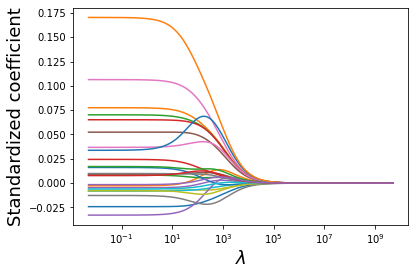

In [50]:
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [51]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, train.PCOS)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

15.811388300841896

Text(0, 0.5, 'Cross-validation error')

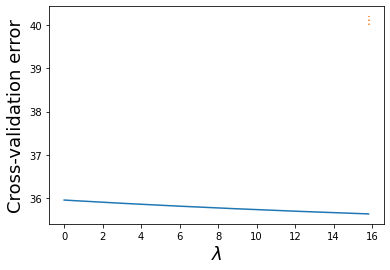

In [70]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

In [53]:
#Test dataset
Xtest = test.loc[:,variables]

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

ValueError: could not convert string to float: '1.99.'

    Cofficients and R^2

In [54]:
#Checking the coefficients of the ridge regression model
ridge.coef_

array([-0.02418568, -0.00275691,  0.00832797,  0.02438926, -0.00474498,
        0.00920434,  0.10641349, -0.01268938, -0.00820131, -0.00783653,
        0.01612062,  0.0775125 ,  0.07022694,  0.0651582 , -0.03288613,
        0.0523746 ,  0.03676458,  0.00987235, -0.00754489, -0.00608822,
        0.03373981,  0.17031392,  0.01704074,  0.00774466, -0.0015499 ])

In [55]:
#R-squared on train data for the ridge regression model
r2_score(ridge.predict(Xstd),train.PCOS)

0.48599770506533135

In [67]:
#R-squared on test data for the ridge regression model
r2_score(pred,np.log(test.PCOS))

TypeError: Expected sequence or array-like, got <class 'statsmodels.regression.linear_model.OLS'>

### Lasso

In [63]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

In [57]:
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, train.PCOS)
    coefs.append(lasso.coef_)

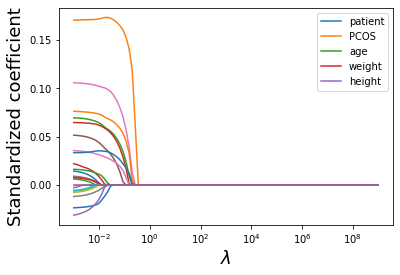

In [58]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

In [59]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, train.PCOS)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.02276467537433475

Text(0, 0.5, 'Cross-validation error')

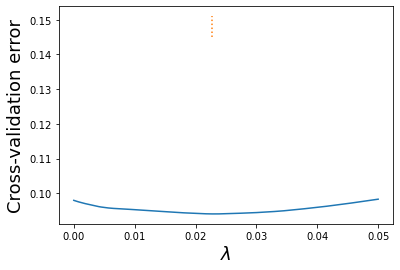

In [69]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

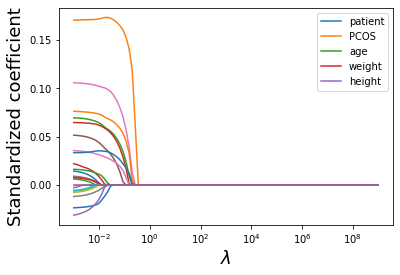

In [61]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

    RMSE on Test:

In [45]:
#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, train.PCOS)
pred=lasso.predict(Xtest_std)

NameError: name 'Xtest_std' is not defined

    Model coefficients and R^2

In [64]:
#Checking the coefficients of the lasso model
lasso.coef_

array([-0.02351009, -0.00022295,  0.00640578,  0.0220767 , -0.00274772,
        0.00858718,  0.10589793, -0.01183341, -0.00751306, -0.00675873,
        0.01452231,  0.07639711,  0.0696198 ,  0.06471373, -0.03108806,
        0.05164571,  0.03581678,  0.00914362, -0.0067773 , -0.00543863,
        0.03358832,  0.17069659,  0.01635357,  0.00757641, -0.00023552])

In [65]:
#R-squared on train data for the lasso model
r2_score(lasso.predict(Xstd),train.PCOS)

0.480810686342351

In [66]:
#R-squared on test data for the lasso model
r2_score(pred,np.log(test.PCOS))

TypeError: Expected sequence or array-like, got <class 'statsmodels.regression.linear_model.OLS'>